In [1]:
from keras import Sequential
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPool2D, Flatten, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

c:\users\herdsric\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: No module named 'tensorflow.python'

In [2]:
dataset = {}
files = ['test-img.data', 'test-label.data', 'train-img.data', 'train-label.data']
for file in files:
    with open('../mnist-dataset/'+file, 'rb') as f:
        data = f.read()
        dataset[file[:-5]] = data

In [3]:
# 整理数据

def convert_to_one_hot(y, C):
    return np.eye(C, dtype=np.uint8)[y.reshape(-1)]

testImg = np.fromiter(dataset['test-img'][16:], np.float)
X_test = testImg.reshape([-1, 28, 28, 1])/255.0 - 0.5

trainImg = np.fromiter(dataset['train-img'][16:], np.float)
trainImg = trainImg.reshape([-1, 28, 28, 1])/255.0 - 0.5

testLabel = np.fromiter(dataset['test-label'][8:], np.uint8)
Y_test = convert_to_one_hot(testLabel, 10)

trainLabel = np.fromiter(dataset['train-label'][8:], np.uint8)
trainLabel = convert_to_one_hot(trainLabel, 10)

validRatio = 0.1
validLen = int(validRatio * len(trainImg))
X_valid, X_train = trainImg[:validLen], trainImg[validLen:]
Y_valid, Y_train = trainLabel[:validLen], trainLabel[validLen:]

In [9]:
# 构建卷积网络

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), batch_input_shape=(None, 28, 28, 1)))
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(3,3), strides=2))
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(BatchNormalization())


model.add(Conv2D(128, kernel_size=(3,3)))
model.add(Activation('relu'))

model.add(Conv2D(256, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         73856     
__________

In [15]:
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.15, height_shift_range=0.15, zoom_range=0.15)
datagen.fit(X_train)

In [21]:
# model.fit(X_train, Y_train,
#           batch_size=256, epochs=20, verbose=1,
#           validation_data=(X_valid, Y_valid), shuffle=True)
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=256),
                    steps_per_epoch=len(X_train), epochs=1, validation_data=(X_valid, Y_valid))

Epoch 1/1
54000/54000 [==============================] - 2473s 46ms/step - loss: 0.0141 - val_loss: 0.0150


In [22]:
p = model.predict(X_test, verbose=1)
accu = np.argmax(p, axis=1) == np.argmax(Y_test, axis=1)
sum(accu) / len(accu)

10000/10000 [==============================] - 1s 139us/step


0.9948

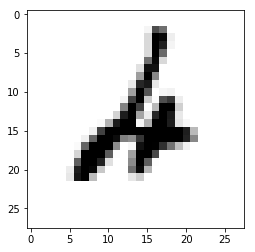

In [24]:
plt.imshow(X_test[247].reshape(28, 28), cmap='binary')

In [23]:
np.argmin(accu)

247

In [25]:
print(np.argmax(p[247]))
print(np.argmax(Y_test[247]))

2
4


In [26]:
model.save('conv-mnist.hdf5')